In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Setup n by n grid
# Input: n = number of grid cell
def field(n):
    # Grid Center Location
    center = np.empty(n)
    edge = np.empty(n+1)
    edge[0] = 0
    for i in range(n):
        center[i] = (2*i+1)*1/n*1/2
        edge[i+1] = (i+1)*1/n
    return center, edge

# Output grid center of current position
def grid_check(center, edge, xi):
    x = xi[0]
    y = xi[1]
    n = len(center)
    for i in range(n):
        minedgex = edge[i]
        maxedgex = edge[i+1]
        for j in range(n):
            minedgey = edge[j]
            maxedgey = edge[j+1]
            if minedgex <= x and x <= maxedgex and minedgey <= y and y <= maxedgey:
                grid_center = np.array([[center[i]], [center[j]]])
    return grid_center

In [2]:
# Wrap2Pi
def wrap2pi(x):
    return np.where(np.abs(x) >= np.pi, (x+np.pi)%(2*np.pi)-np.pi, x)

In [5]:
n = 11
inflate = n
x = np.linspace(0, 1, n)
y = np.linspace(0, 1, n)
X,Y = np.meshgrid(x, y)

# Define Initial, Final position of the aggressor
def position(i_x, inflate):
    return np.array([inflate*x[i_x[0]], inflate*y[i_x[1]]])

i_x0 = (int(0.*n), int(0.*n))
i_xf = (int(0.9*n), int(0.35*n))
x0 = position(i_x0, inflate)
xf = position(i_xf, inflate)
print(x0)
print(xf)

# Define cameras and building placement
ang_lim = [0*np.pi/4, 2*np.pi/4] # [rad]
start_ang = ang_lim[0] # [rad]
fov_ang = np.deg2rad(20) # [rad]
rot_vel = fov_ang/2 # [rad/unit time]
fov_rng = inflate*0.8 # [m]
endtime = int(ang_lim[1]*2/rot_vel) # [unit time]
t = np.linspace(0, endtime-1, endtime)

def fov_cam(start_ang, ang_lim, rot_vel, fov_ang, fov_rng, t):
    # Compute Camera angle (centerline of FOV) at each timestamp t
    ang_prev = start_ang
    fov_ang_vec = np.zeros(len(t))
    dt = t[1]-t[0]
    # Iteration until it hits the angle limit
    iter_lim = ang_lim[1]/rot_vel
    for i in range(len(t)-1):
        if i < iter_lim:
            fov_ang_curr = ang_prev + rot_vel*dt
        # Camera rotates back once reached its rotation limit
        else:
            fov_ang_curr = ang_prev - rot_vel*dt
        ang_prev = fov_ang_curr
        fov_ang_vec[i+1] = fov_ang_curr
    return fov_ang_vec

def position_cam(n_cam, inflate):
    camposx = np.zeros(n_cam)
    camposy = np.zeros(n_cam)
    for i in range(n_cam):
        camx = inflate*(i+1)/(n_cam+1)
        camy = 0
        camposx[i] = camx
        camposy[i] = camy
    return  np.array([camposx, camposy]).transpose()

n_cam = 1
campos = position_cam(n_cam, inflate)
camvec = fov_cam(start_ang, ang_lim, rot_vel, fov_ang, fov_rng, t)
print(campos)
print(np.rad2deg(camvec))

# Define Initial, Final position of the Camera FOV (centerline)
end_in = random.randint(0, len(t)-1)
end_ang = camvec[end_in] # Arbirary number for now
print(end_in)
print(np.rad2deg(camvec[end_in]))

[0. 0.]
[9.9 3.3]
[[5.5 0. ]]
[ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90. 80. 70. 60. 50. 40. 30. 20. 10.]
16
19.99999999999999


In [6]:
center, edge = field(n)
center = inflate*center
edge = inflate*edge
center0 = grid_check(center, edge, x0)
centerf = grid_check(center, edge, xf)

In [7]:
# Compute Cost Function
def costfunc(x0, x1):
    # How do we add restriction from camera FOV?
    s = np.sqrt((x0[0]-x1[0])**2 + (x0[1]-x1[1])**2)
    return s

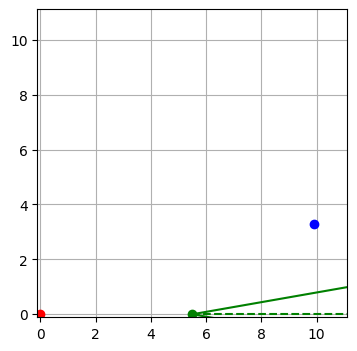

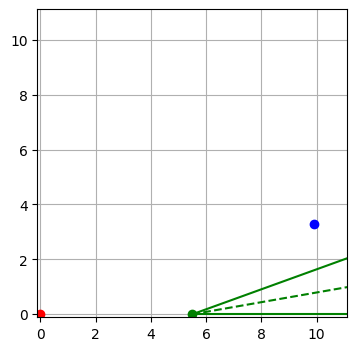

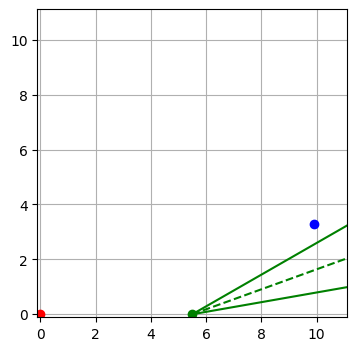

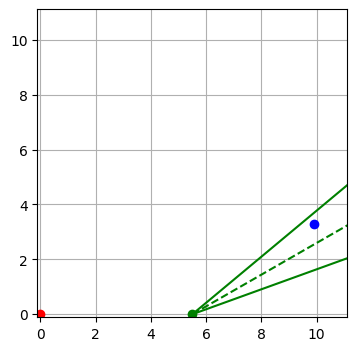

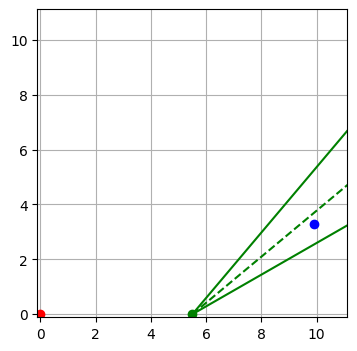

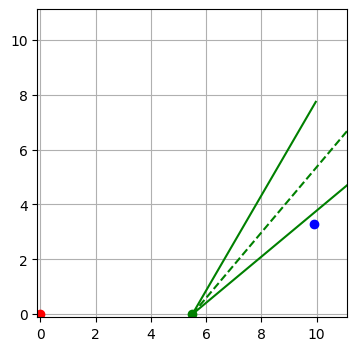

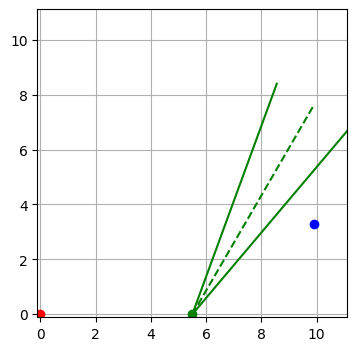

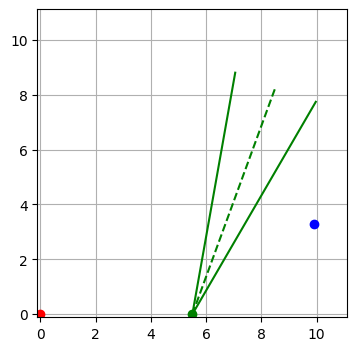

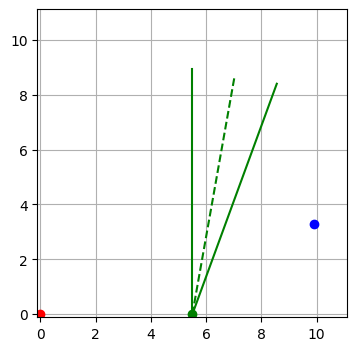

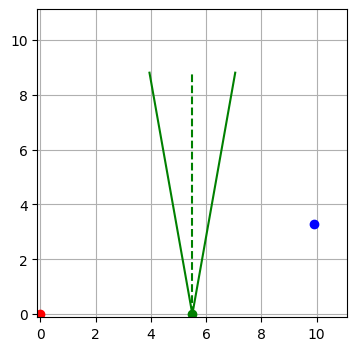

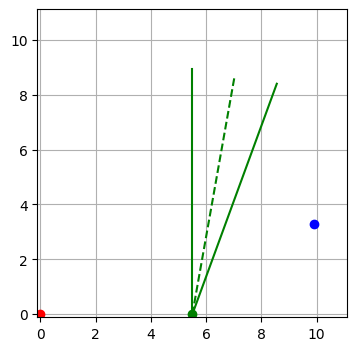

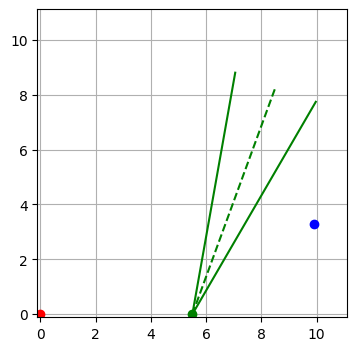

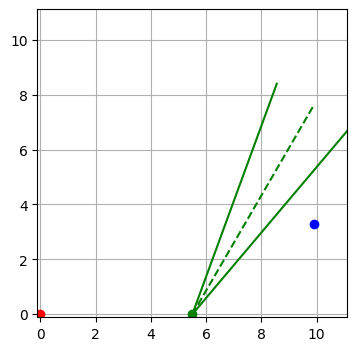

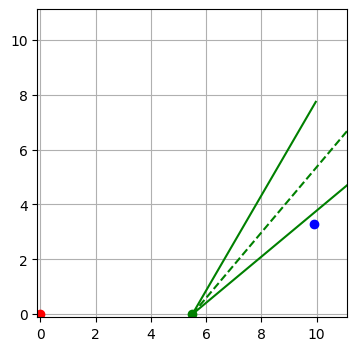

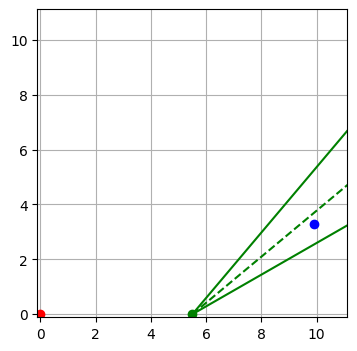

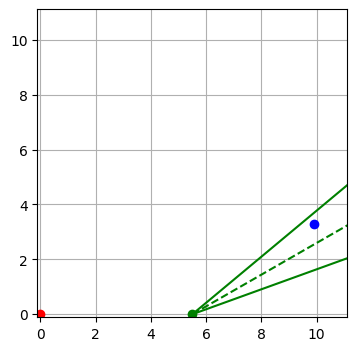

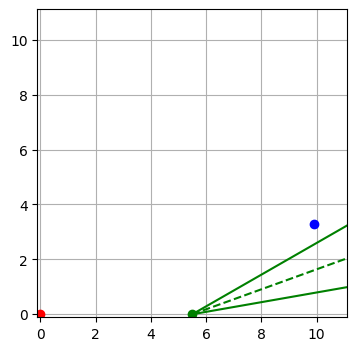

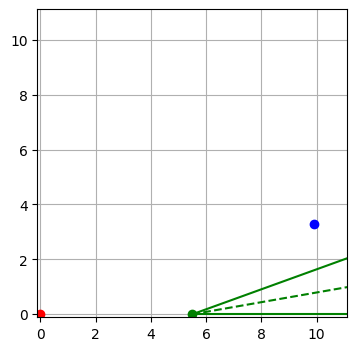

In [8]:
for k in range(len(t)):
    fig = plt.figure(figsize=(4,4))
    # Plot Camera Position
    for i in range(n_cam):
        plt.plot(campos[:,0], campos[:,1], 'og')

    # Plot Camera FOV
    for j in range(n_cam):
        theta = camvec[k]
        xend = campos[j,0]+fov_rng*np.cos(theta)
        yend = campos[j,1]+fov_rng*np.sin(theta)
        plt.plot([campos[j,0], xend], [campos[j,1], yend], '--g')
        
        # FOV LOS
        h = fov_rng*np.tan(fov_ang/2)
        Rprime = np.sqrt(h**2 + fov_rng**2)
        
        xprime1 = [campos[j,0], campos[j,0]+Rprime*np.cos(camvec[k]+fov_ang/2)]
        yprime1 = [campos[j,1], campos[j,1]+Rprime*np.sin(camvec[k]+fov_ang/2)]
        xprime2 = [campos[j,0], campos[j,0]+Rprime*np.cos(camvec[k]-fov_ang/2)]
        yprime2 = [campos[j,1], campos[j,1]+Rprime*np.sin(camvec[k]-fov_ang/2)]
        plt.plot(xprime1, yprime1, '-g')
        plt.plot(xprime2, yprime2, '-g')
        #ax.fill_between(x, y1, y2, color = 'r', alpha=0.2)
        

    # Plot x0, xf
    plt.plot(x0[0], x0[1], 'or')
    plt.plot(xf[0], xf[1], 'ob')

    # Plot Setting
    lim = [0, inflate*1, 0, inflate*1]
    tol = 0.01*inflate
    plt.grid()
    plt.xlim(-tol, inflate*1+tol)
    plt.ylim(-tol, inflate*1+tol)
    plt.show()

In [9]:
import copy

# Initialize Final Point
i_x_prev = i_xf
i_theta_prev = end_ang
i_theta = i_theta_prev
i_x = i_x_prev
V = np.zeros((n, n))
live = [[i_x[0], i_x[1], i_theta]]

# Bound within map
def bound(i_x):
    return (i_x[0] >= 0 and i_x[0]<n and i_x[1] >= 0 and i_x[1]<n)

# Bound outside of camera FOV
def bound_cam(i_x, campos, fov_ang_curr, fov_ang, fov_rng):
    # distance to node
    dist = np.sqrt((campos[0]-i_x[0])**2 + (campos[1]-i_x[1])**2)
    # Angle to node
    ang = np.arctan2(i_x[1]-campos[1], i_x[0]-campos[0])
    return (ang >= fov_ang_curr-fov_ang/2 and ang < fov_ang_curr+fov_ang/2 and dist >= 0 and dist < fov_rng)

# Possible Actions
movement = [
    (1, 0), (-1, 0),  # Horizontal
    (0, 1), (0, -1),  # Vertical
    (0, 0)            # Stationary
]


# Compute moves from current node
V_data = []
kek = end_in
while len(live) > 0:
    new = set()
    end_in_prev = kek-1
    if kek == 0:
        end_in_prev = end_in_prev+len(t)
    for p in live:
        for a in movement:
            pa = (p[0] - a[0], p[1] - a[1])
            for j in range(len(campos)):
                if bound(pa) and not bound_cam(pa, campos[j], camvec[end_in_prev], fov_ang, fov_rng):
                    V_new = costfunc(position(p, inflate), position(pa, inflate)) + V[p[0], p[1]]
                    V_old = V[pa[0], pa[1]]
                    if V_old == 0 or V_new < V_old:
                        V[pa[0], pa[1]] = V_new
                        new.add((pa[0], pa[1], camvec[end_in_prev]))
    live = new
    V_data.append(copy.copy(V))
    kek = end_in_prev
print(len(V_data))

17


In [10]:
# Compute Optimal Path
p = i_x0
p_hist_opt = [p]
count = 0
while p != i_xf:
    # Find current time to check where the camera angle is:
    curr_time = count%len(t)
    pa_opt = None
    V_old = V[p[0], p[1]]
    for a in movement:
        pa = (p[0] + a[0], p[1] + a[1])
        for j in range(len(campos)):
            if bound(pa) and not bound_cam(pa, campos[j], camvec[curr_time], fov_ang, fov_rng):
                V_new = V[pa[0], pa[1]]
                if pa_opt is None or pa == i_xf or (V_new < V_opt and V_new < V_old):
                    V_opt = V_new
                    pa_opt = pa
            if pa == i_xf: break
    if count > 1000: break
    p = pa_opt
    p_hist_opt.append(p)
    count += 1
pos_hist_opt = np.array([position(p, inflate) for p in p_hist_opt])
print(len(pos_hist_opt))

13


In [22]:
import matplotlib.animation

# video animation
from tempfile import NamedTemporaryFile
from IPython.display import HTML

def anim_dyn_prog(V_data):
    nV = len(V_data)
    nP = len(pos_hist_opt)
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(111)
    ax.pcolor(X, Y, V_data[0].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
    plt.plot([x0[0]], [x0[1]], 'go')
    plt.plot([xf[0]], [xf[1]], 'ro')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('dynamic programming cost to go for each state')
    def update(i):
        if i < nV:
            ax.pcolor(X, Y, V_data[i].T, vmin=V_data[-1].min(), vmax=V_data[-1].max())
        else:
            j = i - nV + 1
            ax.plot(pos_hist_opt[:j,0], pos_hist_opt[:j,1] , '-k', linewidth=5)
    return matplotlib.animation.FuncAnimation(fig, update, frames=nV + nP)

In [23]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython import display
import numpy as np
x = np.linspace(0, 2*np.pi, 100)
y = np.sin(x)
# Turn off matplotlib plot in Notebook
plt.ioff()
# Pass the ffmpeg path
fig, ax = plt.subplots()
line, = ax.plot([])
ax.set_xlim(0, 2*np.pi)
ax.set_ylim(-1.1, 1.1)
anim = FuncAnimation(fig, anim_dyn_prog(V_data), frames=10, interval=20)
video = anim.to_html5_video()
html = display.HTML(video)
display.display(html)

TypeError: 'FuncAnimation' object is not callable

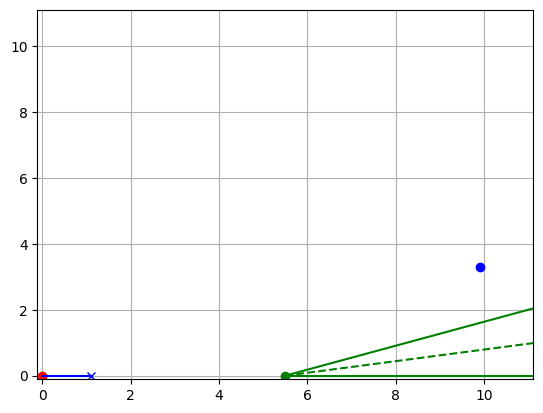

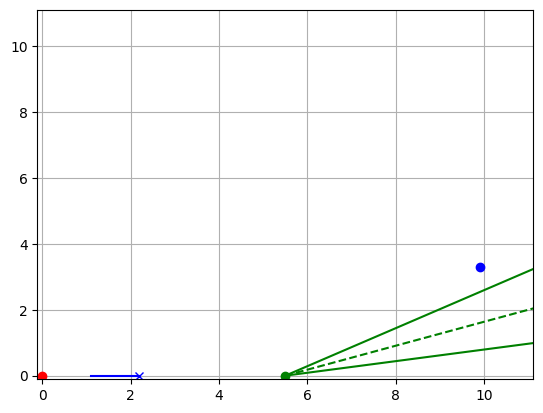

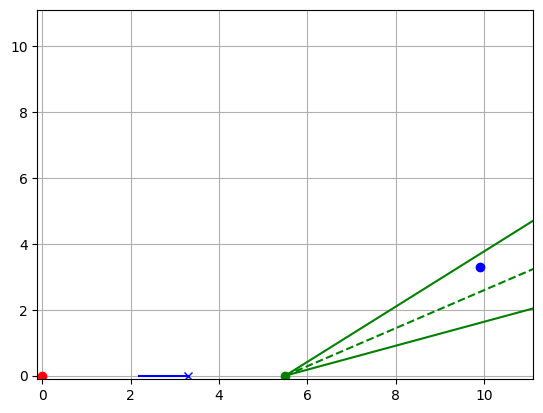

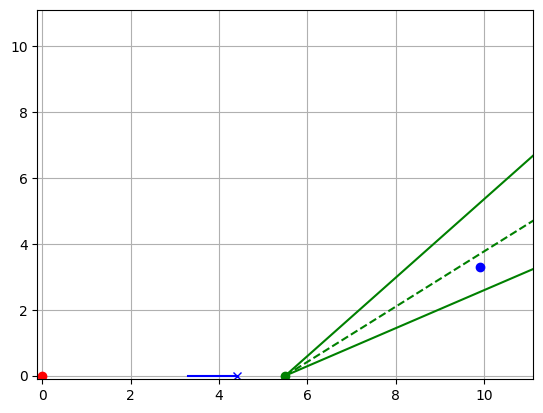

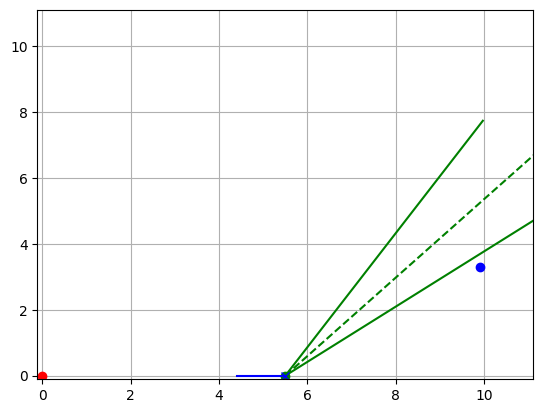

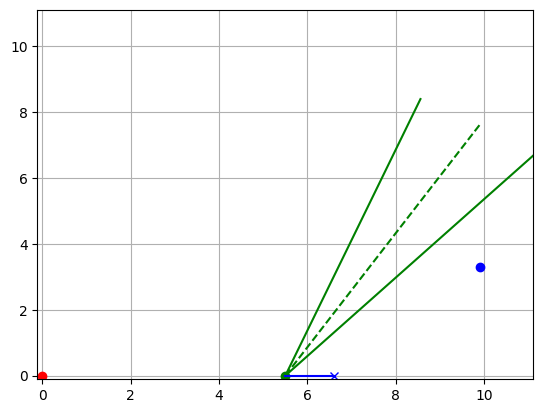

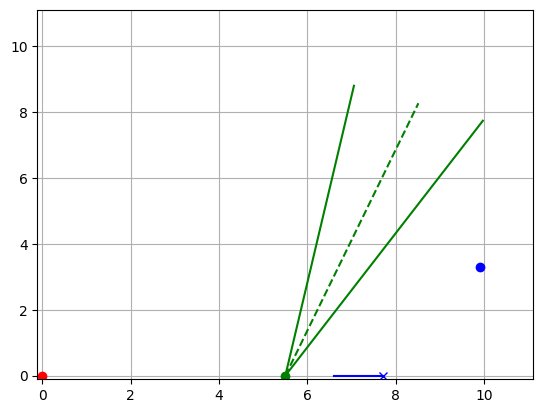

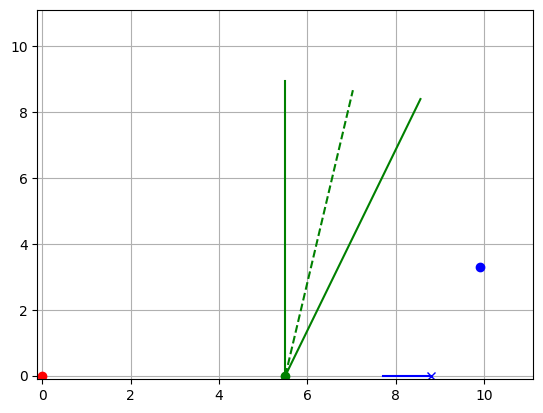

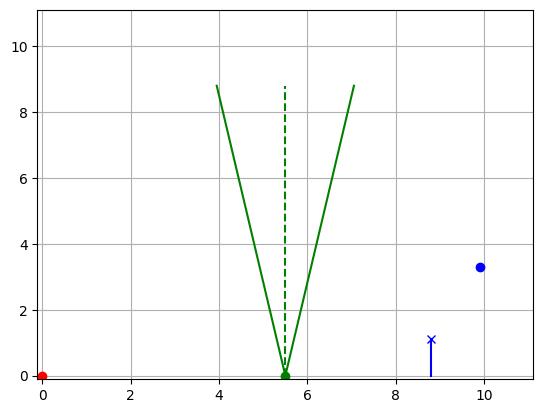

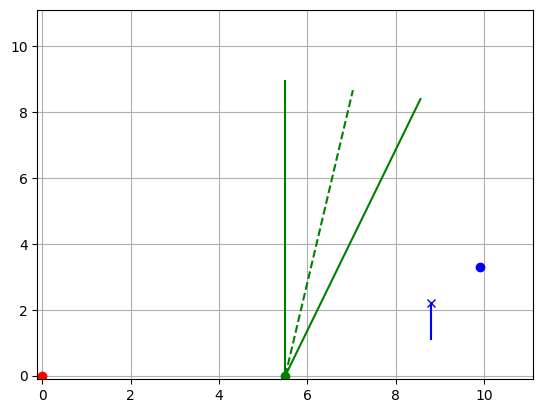

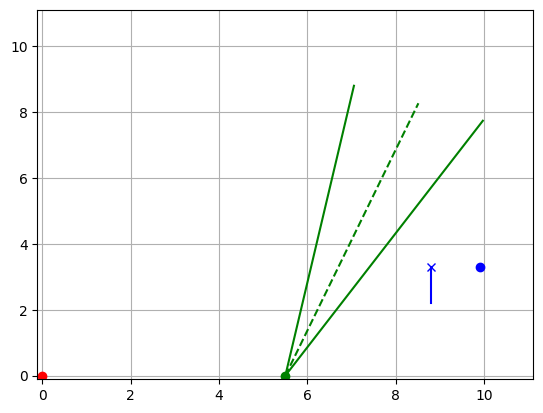

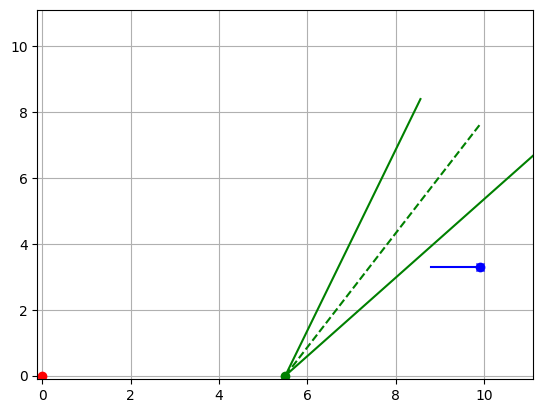

In [25]:
for k in range(len(pos_hist_opt)-1):
    fig = plt.figure()
    # Plot Camera Position
    for i in range(n_cam):
        plt.plot(campos[:,0], campos[:,1], 'og')

    # Plot Camera FOV
    for j in range(n_cam):
        curr_time = (k+1)%len(t)
        theta = camvec[curr_time]
        xend = campos[j,0]+fov_rng*np.cos(theta)
        yend = campos[j,1]+fov_rng*np.sin(theta)
        plt.plot([campos[j,0], xend], [campos[j,1], yend], '--g')
        
        # FOV LOS
        h = fov_rng*np.tan(fov_ang/2)
        Rprime = np.sqrt(h**2 + fov_rng**2)
        
        xprime1 = [campos[j,0], campos[j,0]+Rprime*np.cos(theta+fov_ang/2)]
        yprime1 = [campos[j,1], campos[j,1]+Rprime*np.sin(theta+fov_ang/2)]
        xprime2 = [campos[j,0], campos[j,0]+Rprime*np.cos(theta-fov_ang/2)]
        yprime2 = [campos[j,1], campos[j,1]+Rprime*np.sin(theta-fov_ang/2)]
        plt.plot(xprime1, yprime1, '-g')
        plt.plot(xprime2, yprime2, '-g')
        #ax.fill_between(x, y1, y2, color = 'r', alpha=0.2)
        

    # Plot x0, xf
    plt.plot(x0[0], x0[1], 'or')
    plt.plot(xf[0], xf[1], 'ob')
    
    # Plot Intermediate Position
    plt.plot(pos_hist_opt[k+1,0], pos_hist_opt[k+1,1], 'xb')
    plt.plot([pos_hist_opt[k,0], pos_hist_opt[k+1,0]], [pos_hist_opt[k,1], pos_hist_opt[k+1,1]], '-b')

    # Plot Setting
    lim = [0, inflate*1, 0, inflate*1]
    tol = 0.01*inflate
    plt.grid()
    plt.xlim(-tol, inflate*1+tol)
    plt.ylim(-tol, inflate*1+tol)
    plt.show()

In [ ]:
fig = plt.figure()
# Plot Center and Grid Edge
for i in range(n):
    for j in range(n):
        plt.plot(center[i], center[j], '.k')
for i in range(n+1):
    plt.plot([edge[i], edge[i]], [0, inflate*1], '--k')
    plt.plot([0, inflate*1], [edge[i], edge[i]], '--k')

# Plot Camera Position
for i in range(n_cam):
    plt.plot(campos[:,0], campos[:,1], 'og')

# Plot Camera FOV
for i in range(len(t)):
    theta = camvec[i]
    xend = campos[:,0]+fov_rng*np.cos(theta)
    yend = campos[:,1]+fov_rng*np.sin(theta)
    plt.plot([campos[:,0], xend], [campos[:,1], yend], '-r')
    
# Plot x0, xf
plt.plot(x0[0], x0[1], 'xr')
plt.plot(xf[0], xf[1], 'xb')
plt.plot(center0[0], center0[1], 'or')
plt.plot(centerf[0], centerf[1], 'ob')

# Plot Optimal Path
plt.plot(pos_hist_opt[:,0], pos_hist_opt[:,1], '-b')

# Plot Setting
lim = [0, inflate*1, 0, inflate*1]
plt.axis(lim)
plt.axis('equal')
plt.show()

In [ ]:
from matplotlib.animation import FuncAnimation

# Figure Initialization
fig = plt.figure()

# Make x-axis, y-axis
axis = plt.axis(xlim=(0, inflate*1), ylim=(0, inflate*1))

